In [ ]:
from google.colab import drive
import torch
import os

# 1. Drive Bağlantısı
print("Google Drive bağlanıyor...")
drive.mount('/content/drive')

# 2. GPU Kontrolü
if torch.cuda.is_available():
    print(f"✅ GPU Hazır: {torch.cuda.get_device_name(0)}")
else:
    print("❌ GPU bulunamadı! Lütfen 'Runtime' ayarlarından GPU seçtiğinizden emin olun.")

# 3. Klasör Yolu Kontrolü (Drive'da klasör gerçekten orada mı?)
DRIVE_PATH = '/content/drive/MyDrive/bird_dataset_200category'

if os.path.exists(DRIVE_PATH):
    print(f"✅ Klasör bulundu: {DRIVE_PATH}")
else:
    print(f"❌ Klasör bulunamadı: {DRIVE_PATH}")
    print("Lütfen Drive'daki klasör isminin tam olarak 'bird_dataset_200category' olduğundan emin olun.")

Google Drive bağlanıyor...
Mounted at /content/drive
✅ GPU Hazır: NVIDIA A100-SXM4-40GB
✅ Klasör bulundu: /content/drive/MyDrive/bird_dataset_200category


In [ ]:
import os
import shutil
from tqdm.notebook import tqdm  # İlerleme çubuğu için kütüphane

# Kaynak ve Hedef Yollar
SOURCE_ROOT = '/content/drive/MyDrive/bird_dataset_200category'
DEST_ROOT = '/content/temp_data'

def copy_dir_with_progress(src, dst, description):
    """
    Klasörü ilerleme çubuğu ile kopyalar.
    """
    # 1. Önce kopyalanacak toplam dosya sayısını hesapla
    print(f"📊 '{description}' için dosya sayısı hesaplanıyor... (Biraz bekleyin)")
    total_files = 0
    for root, dirs, files in os.walk(src):
        total_files += len(files)

    print(f"✅ Toplam {total_files} dosya bulundu. Kopyalama başlıyor...")

    # 2. Kopyalama işlemi
    if not os.path.exists(dst):
        os.makedirs(dst)

    # İlerleme çubuğunu oluştur
    with tqdm(total=total_files, desc=description, unit='img') as pbar:
        for root, dirs, files in os.walk(src):
            # Hedef klasör yapısını oluştur
            rel_path = os.path.relpath(root, src)
            dest_dir = os.path.join(dst, rel_path)

            if not os.path.exists(dest_dir):
                os.makedirs(dest_dir)

            # Dosyaları tek tek kopyala ve çubuğu güncelle
            for file in files:
                src_file = os.path.join(root, file)
                dst_file = os.path.join(dest_dir, file)

                shutil.copy2(src_file, dst_file) # Dosyayı kopyala
                pbar.update(1) # Çubuğu 1 ilerlet

# --- İŞLEM BAŞLIYOR ---

# 1. Eski kalıntıları temizle (Temiz başlangıç için)
if os.path.exists(DEST_ROOT):
    print("🧹 Eski 'temp_data' klasörü temizleniyor...")
    shutil.rmtree(DEST_ROOT)

# 2. Train Klasörünü Kopyala
SRC_TRAIN = os.path.join(SOURCE_ROOT, 'Train')
DST_TRAIN = os.path.join(DEST_ROOT, 'Train')
copy_dir_with_progress(SRC_TRAIN, DST_TRAIN, "TRAIN Seti Kopyalanıyor")

# 3. Test Klasörünü Kopyala
SRC_TEST = os.path.join(SOURCE_ROOT, 'Test')
DST_TEST = os.path.join(DEST_ROOT, 'Test')
copy_dir_with_progress(SRC_TEST, DST_TEST, "TEST Seti Kopyalanıyor")

print("\n🚀 TÜM DOSYALAR BAŞARIYLA KOPYALANDI!")

📊 'TRAIN Seti Kopyalanıyor' için dosya sayısı hesaplanıyor... (Biraz bekleyin)
✅ Toplam 9414 dosya bulundu. Kopyalama başlıyor...


TRAIN Seti Kopyalanıyor:   0%|          | 0/9414 [00:00<?, ?img/s]

📊 'TEST Seti Kopyalanıyor' için dosya sayısı hesaplanıyor... (Biraz bekleyin)
✅ Toplam 2374 dosya bulundu. Kopyalama başlıyor...


TEST Seti Kopyalanıyor:   0%|          | 0/2374 [00:00<?, ?img/s]


🚀 TÜM DOSYALAR BAŞARIYLA KOPYALANDI!


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os

# 1. HIZLI DİSK YOLLARI
TRAIN_DIR = '/content/temp_data/Train'
TEST_DIR = '/content/temp_data/Test'

# EfficientNet için önerilen boyut
IMG_SIZE = 380
BATCH_SIZE = 32 # A100 GPU kullandığımız için yüksek tutabiliriz

# Cihaz
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"✅ Kullanılan Cihaz: {device}")

# 2. VERİ DÖNÜŞÜMLERİ (Sadeleştirilmiş)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMG_SIZE + 32),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 3. VERİLERİ YÜKLEME
print("\n📊 Veriler analiz ediliyor...")
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(TEST_DIR, transform=data_transforms['test'])

# num_workers=4 verip, pin_memory=True yaparak hızı artırıyoruz
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

class_names = train_dataset.classes
dataset_sizes = {'train': len(train_dataset), 'test': len(test_dataset)}

print(f"✅ Eğitim Resmi Sayısı: {dataset_sizes['train']}")
print(f"✅ Test Resmi Sayısı: {dataset_sizes['test']}")
print(f"✅ Sınıf (Kuş Türü) Sayısı: {len(class_names)}")

# KONTROL NOKTASI
if len(class_names) != 200:
    print(f"⚠️ DİKKAT: Beklenen 200 sınıf yerine {len(class_names)} sınıf bulundu!")
else:
    print("✅ Mükemmel! 200 sınıfın hepsi tam.")

# 4. MODELİ İNDİRME VE HAZIRLAMA
print("\n🤖 EfficientNet-B4 Modeli Hazırlanıyor...")
weights = models.EfficientNet_B4_Weights.IMAGENET1K_V1
model = models.efficientnet_b4(weights=weights)

# Başlangıçta özellikleri dondur (Feature Extraction)
for param in model.parameters():
    param.requires_grad = False

# Son katmanı (Classifier) değiştir
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# Modeli GPU'ya taşı
model = model.to(device)

print("🚀 Model GPU'ya yüklendi. EĞİTİME HAZIRIZ!")

✅ Kullanılan Cihaz: cuda:0

📊 Veriler analiz ediliyor...
✅ Eğitim Resmi Sayısı: 9414
✅ Test Resmi Sayısı: 2374
✅ Sınıf (Kuş Türü) Sayısı: 200
✅ Mükemmel! 200 sınıfın hepsi tam.

🤖 EfficientNet-B4 Modeli Hazırlanıyor...
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 126MB/s]


🚀 Model GPU'ya yüklendi. EĞİTİME HAZIRIZ!


In [ ]:
import time
import copy
import torch.optim as optim

# --- 1. EĞİTİM FONKSİYONU ---
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    # En iyi modelin ağırlıklarını saklamak için
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # İstatistikleri tutacağımız liste
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Her epoch'ta Training ve Test fazı
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Eğitim modu
                dataloader = train_loader
            else:
                model.eval()   # Değerlendirme modu
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            # Veriler üzerinde döngü
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward (İleri Yayılım)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward (Geri Yayılım) - Sadece eğitimde
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # İstatistikler
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Kayıt et
            if phase == 'train':
                history['train_acc'].append(epoch_acc.item())
                history['train_loss'].append(epoch_loss)
            else:
                history['test_acc'].append(epoch_acc.item())
                history['test_loss'].append(epoch_loss)

            # En iyi modeli kopyala
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print() # Boş satır

    time_elapsed = time.time() - since
    print(f'Eğitim tamamlandı: {time_elapsed // 60:.0f}dk {time_elapsed % 60:.0f}sn')
    print(f'En Yüksek Test Başarısı (Acc): {best_acc:.4f}')

    # En iyi ağırlıkları yükle
    model.load_state_dict(best_model_wts)
    return model, history

# --- 2. EĞİTİMİ BAŞLAT (ISINMA TURU - 3 EPOCH) ---
print("🔥 ISINMA TURU (WARM-UP) BAŞLIYOR...")
print("Amaç: Sadece son katmanı alıştırmak.")

criterion = nn.CrossEntropyLoss()
# Sadece classifier katmanını eğitiyoruz
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Start!
model, history_warmup = train_model(model, criterion, optimizer, num_epochs=3)

🔥 ISINMA TURU (WARM-UP) BAŞLIYOR...
Amaç: Sadece son katmanı alıştırmak.
Epoch 1/3
----------
train Loss: 4.8134 Acc: 0.1811
test Loss: 4.1222 Acc: 0.4600

Epoch 2/3
----------
train Loss: 3.8974 Acc: 0.4066
test Loss: 3.2971 Acc: 0.5518

Epoch 3/3
----------
train Loss: 3.2571 Acc: 0.4973
test Loss: 2.7588 Acc: 0.5944

Eğitim tamamlandı: 1dk 18sn
En Yüksek Test Başarısı (Acc): 0.5944


In [ ]:
# --- FINE-TUNING AYARLARI ---
print("🔓 Tüm model kilitleri açılıyor (Unfreezing)...")

# 1. Tüm katmanların kilidini aç
for param in model.parameters():
    param.requires_grad = True

# 2. Optimizer'ı güncelle (Düşük Learning Rate ile)
# DİKKAT: LR 0.001'den 0.0001'e düşürüldü.
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

# 3. Eğitimi Başlat (10 Epoch)
print("🚀 Fine-Tuning Başlıyor (10 Epoch)...")
print("Bu işlem modelin detayları öğrenmesini sağlayacak.")

# Eğitimi başlat
model, history_ft = train_model(model, criterion, optimizer_ft, num_epochs=10)

🔓 Tüm model kilitleri açılıyor (Unfreezing)...
🚀 Fine-Tuning Başlıyor (10 Epoch)...
Bu işlem modelin detayları öğrenmesini sağlayacak.
Epoch 1/10
----------
train Loss: 1.7685 Acc: 0.6081
test Loss: 0.9016 Acc: 0.7675

Epoch 2/10
----------
train Loss: 1.2394 Acc: 0.6877
test Loss: 0.7208 Acc: 0.7991

Epoch 3/10
----------
train Loss: 1.0392 Acc: 0.7332
test Loss: 0.6274 Acc: 0.8252

Epoch 4/10
----------
train Loss: 0.9791 Acc: 0.7427
test Loss: 0.5879 Acc: 0.8336

Epoch 5/10
----------
train Loss: 0.9028 Acc: 0.7622
test Loss: 0.5529 Acc: 0.8412

Epoch 6/10
----------
train Loss: 0.8366 Acc: 0.7793
test Loss: 0.5239 Acc: 0.8547

Epoch 7/10
----------
train Loss: 0.8172 Acc: 0.7848
test Loss: 0.5254 Acc: 0.8505

Epoch 8/10
----------
train Loss: 0.7588 Acc: 0.8035
test Loss: 0.5137 Acc: 0.8551

Epoch 9/10
----------
train Loss: 0.7155 Acc: 0.8096
test Loss: 0.5006 Acc: 0.8585

Epoch 10/10
----------
train Loss: 0.6846 Acc: 0.8157
test Loss: 0.5100 Acc: 0.8576

Eğitim tamamlandı: 11dk 

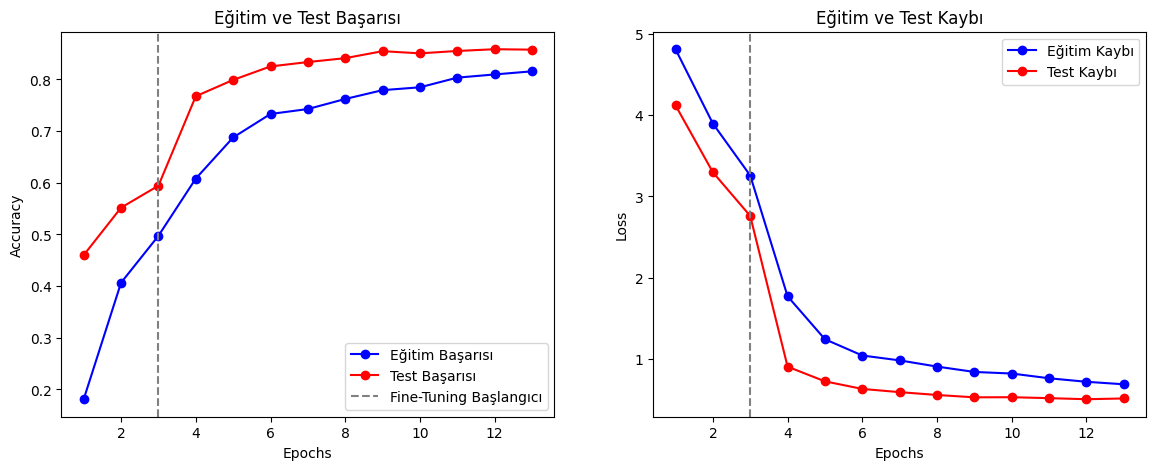

In [ ]:
import matplotlib.pyplot as plt

# İki aşamanın geçmişini birleştiriyoruz
acc = history_warmup['train_acc'] + history_ft['train_acc']
val_acc = history_warmup['test_acc'] + history_ft['test_acc']
loss = history_warmup['train_loss'] + history_ft['train_loss']
val_loss = history_warmup['test_loss'] + history_ft['test_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Doğruluk Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Eğitim Başarısı')
plt.plot(epochs, val_acc, 'ro-', label='Test Başarısı')
# Isınma turunun bittiği yeri işaretleyelim
plt.axvline(x=3, color='gray', linestyle='--', label='Fine-Tuning Başlangıcı')
plt.title('Eğitim ve Test Başarısı')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Kayıp Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'ro-', label='Test Kaybı')
plt.axvline(x=3, color='gray', linestyle='--')
plt.title('Eğitim ve Test Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

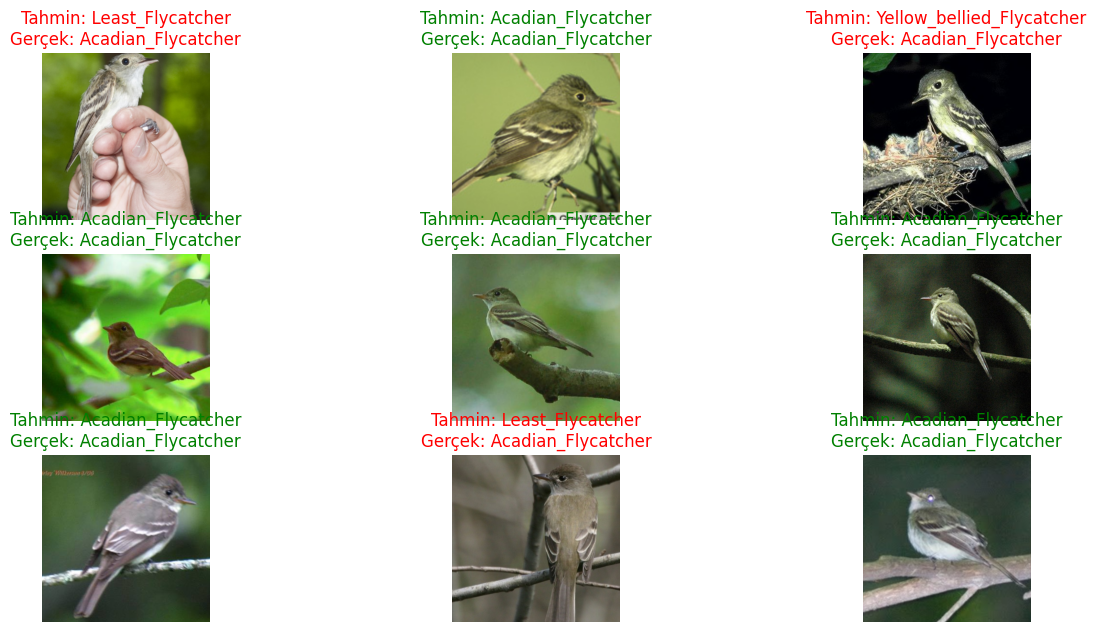

In [ ]:
import numpy as np

def imshow(inp, title=None):
    """Tensor'u resme çevirir"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3 + 1, 3, images_so_far)

                predicted = class_names[preds[j]]
                actual = class_names[labels[j]]

                # Doğruysa Yeşil, Yanlışsa Kırmızı
                color = 'green' if predicted == actual else 'red'

                ax.set_title(f'Tahmin: {predicted}\nGerçek: {actual}', color=color)
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 9 tane rastgele resim üzerinde test edelim
visualize_model(model, num_images=9)

In [ ]:
import os
import torch
import torchvision.utils as vutils
from tqdm.notebook import tqdm # İlerleme çubuğu için

# --- 1. AYARLAR ---
# Hedef Klasör
save_dir = '/content/drive/MyDrive/bird_dataset_200category/Augmentation_Ornekleri_FULL'

# Klasörü oluştur
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"📂 Klasör oluşturuldu: {save_dir}")
else:
    print(f"📂 Klasör zaten var. Üzerine yazılacak: {save_dir}")

# --- 2. HAZIRLIK ---
# Renk düzeltme için (Normalization'ı tersine çevirme)
mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)

print(f"🚀 Toplam {len(train_dataset)} adet resim işlenip Drive'a kaydedilecek.")
print("⚠️ UYARI: Bu işlem Google Drive hızına bağlı olarak uzun sürebilir.")

# --- 3. DÖNGÜ (Tüm Veri Seti - 1 Epoch) ---
count = 0

# tqdm ile ilerleme çubuğu ekleyelim
for batch_idx, (inputs, classes) in enumerate(tqdm(train_loader, desc="Kaydediliyor")):

    # Batch içindeki her bir resim için
    for i in range(inputs.size(0)):
        img_tensor = inputs[i]

        # 1. Denormalize et (Görüntüyü düzelt)
        img_tensor = img_tensor * std + mean
        img_tensor = torch.clamp(img_tensor, 0, 1) # Taşmaları önle

        # 2. Dosya ismini oluştur
        # Format: SınıfAdı_OrijinalSıra_Aug.jpg
        class_name = class_names[classes[i]]
        # Benzersiz isim için global sayaç (count) kullanıyoruz
        file_name = f"{class_name}_{count}_aug.jpg"
        save_path = os.path.join(save_dir, file_name)

        # 3. Kaydet
        try:
            vutils.save_image(img_tensor, save_path)
        except Exception as e:
            print(f"Hata oluştu ({file_name}): {e}")

        count += 1

print(f"\n✅ İŞLEM TAMAMLANDI!")
print(f"Toplam {count} adet augmentation uygulanmış resim şuraya kaydedildi:")
print(save_dir)

📂 Klasör oluşturuldu: /content/drive/MyDrive/bird_dataset_200category/Augmentation_Ornekleri_FULL
🚀 Toplam 9414 adet resim işlenip Drive'a kaydedilecek.
⚠️ UYARI: Bu işlem Google Drive hızına bağlı olarak uzun sürebilir.


Kaydediliyor:   0%|          | 0/295 [00:00<?, ?it/s]


✅ İŞLEM TAMAMLANDI!
Toplam 9414 adet augmentation uygulanmış resim şuraya kaydedildi:
/content/drive/MyDrive/bird_dataset_200category/Augmentation_Ornekleri_FULL


In [ ]:
from google.colab import files

# Modelin Drive'daki yolu
model_path = '/content/drive/MyDrive/bird_dataset_200category/efficientnetb4_bird_model_85acc.pth'

print("⬇️ İndirme işlemi başlatılıyor...")
try:
    files.download(model_path)
except Exception as e:
    print(f"Hata oluştu: {e}")

⬇️ İndirme işlemi başlatılıyor...
Hata oluştu: Cannot find file: /content/drive/MyDrive/bird_dataset_200category/efficientnetb4_bird_model_85acc.pth


In [ ]:
import torch
from google.colab import files

# 1. Modeli Colab'in kendi içine (kısa yola) kaydet
local_path = 'model_son.pth'
print("💾 Model hazırlanıyor...")
torch.save(model.state_dict(), local_path)

# 2. İndirmeyi başlat
print("⬇️ İndirme başlatılıyor...")
files.download(local_path)

💾 Model hazırlanıyor...
⬇️ İndirme başlatılıyor...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os

# Eğitim verilerinin olduğu klasör (Drive'daki yol)
TRAIN_DIR = '/content/drive/MyDrive/bird_dataset_200category/Train'

# Klasör isimlerini oku ve sırala (Model eğitimi alfabetik sıraya göre yaptı)
class_names = sorted(os.listdir(TRAIN_DIR))

# Listeyi Python formatında yazdır
print("CLASS_NAMES = [")
for i, name in enumerate(class_names):
    # Son eleman değilse virgül koy, son elemansa koyma
    comma = "," if i < len(class_names) - 1 else ""
    print(f'    "{name}"{comma}')
print("]")

print(f"\n✅ Toplam {len(class_names)} sınıf ismi listelendi.")

CLASS_NAMES = [
    "Acadian_Flycatcher",
    "American_Crow",
    "American_Goldfinch",
    "American_Pipit",
    "American_Redstart",
    "American_Three_toed_Woodpecker",
    "Anna_Hummingbird",
    "Artic_Tern",
    "Baird_Sparrow",
    "Baltimore_Oriole",
    "Bank_Swallow",
    "Barn_Swallow",
    "Bay_breasted_Warbler",
    "Belted_Kingfisher",
    "Bewick_Wren",
    "Black_Tern",
    "Black_and_white_Warbler",
    "Black_billed_Cuckoo",
    "Black_capped_Vireo",
    "Black_footed_Albatross",
    "Black_throated_Blue_Warbler",
    "Black_throated_Sparrow",
    "Blue_Grosbeak",
    "Blue_Jay",
    "Blue_headed_Vireo",
    "Blue_winged_Warbler",
    "Boat_tailed_Grackle",
    "Bobolink",
    "Bohemian_Waxwing",
    "Brandt_Cormorant",
    "Brewer_Blackbird",
    "Brewer_Sparrow",
    "Bronzed_Cowbird",
    "Brown_Creeper",
    "Brown_Pelican",
    "Brown_Thrasher",
    "Cactus_Wren",
    "California_Gull",
    "Canada_Warbler",
    "Cape_Glossy_Starling",
    "Cape_May_Warbler",
 